# Javier Blanco
Contact: javierblancordero@gmail.com

Linkedin: https://www.linkedin.com/in/javier-blanco-cordero-71373656/
## causaLens - Code Test
14/06/2020

# 0. Helpers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from statsmodels.tsa import seasonal
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics import tsaplots
from statsmodels.tsa._stl import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

In [2]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 5)
register_matplotlib_converters()

In [3]:
def month_diff(a, b):
    return 12 * (a.year - b.year) + (a.month - b.month)

def year_diff(a, b):
    return (a.year - b.year)

In [4]:
def plot_AC_and_PAC(series, lags):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    
    tsaplots.plot_acf(series, ax=ax1, lags=lags, alpha=.05)
    ax1.set_title('AC '+series.name)
    
    tsaplots.plot_pacf(series, ax=ax2, lags=lags, alpha=.05)
    ax2.set_title('PAC ' +series.name)
    plt.show()

In [5]:
def plot_residuals_distribution(total_residuals, train_residuals, test_residuals, lags):
    plt.plot(train_residuals.index, train_residuals, color='blue', alpha=.75, label='train')
    plt.plot(test_residuals.index, test_residuals, color='red', alpha=.75, label='test')
    plt.title('Residuals evolution', size=15)
    plt.axvline(train_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.legend()
    plt.show()
    
    fig, (ax1,ax2) = plt.subplots(1, 2)
    tsaplots.plot_acf(train_residuals, ax=ax1, lags=lags, alpha=.05, label='train', color='blue')
    tsaplots.plot_acf(test_residuals, ax=ax1, lags=lags, alpha=.05, label='test', color='red')
    ax1.set_title('Residuals Autocorrelation')
    
    ax2.set_title('Residuals Distribution')
    sns.distplot(train_residuals, ax=ax2, label='train', color='blue')
    sns.distplot(test_residuals, ax=ax2, label='test', color='red')
    plt.axvline(0, color='black', linewidth=1)
    
    plt.legend()
    plt.show()

# 1. Import data
### 1.1 Load csv

In [7]:
# Load and check data types
main_df = pd.read_csv('Data/AirQualityUCI.csv', sep=';', decimal=",") # decimal!
main_df.replace(-200, np.NaN) # Replace nulls with propper tag
main_df.replace('-200', np.NaN) # Replace nulls with propper tag
display(main_df.head())
main_df.info()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


In [8]:
# Check available dates and intervals
date_column = 'Date'
main_df[date_column].values[:60]

array(['10/03/2004', '10/03/2004', '10/03/2004', '10/03/2004',
       '10/03/2004', '10/03/2004', '11/03/2004', '11/03/2004',
       '11/03/2004', '11/03/2004', '11/03/2004', '11/03/2004',
       '11/03/2004', '11/03/2004', '11/03/2004', '11/03/2004',
       '11/03/2004', '11/03/2004', '11/03/2004', '11/03/2004',
       '11/03/2004', '11/03/2004', '11/03/2004', '11/03/2004',
       '11/03/2004', '11/03/2004', '11/03/2004', '11/03/2004',
       '11/03/2004', '11/03/2004', '12/03/2004', '12/03/2004',
       '12/03/2004', '12/03/2004', '12/03/2004', '12/03/2004',
       '12/03/2004', '12/03/2004', '12/03/2004', '12/03/2004',
       '12/03/2004', '12/03/2004', '12/03/2004', '12/03/2004',
       '12/03/2004', '12/03/2004', '12/03/2004', '12/03/2004',
       '12/03/2004', '12/03/2004', '12/03/2004', '12/03/2004',
       '12/03/2004', '12/03/2004', '13/03/2004', '13/03/2004',
       '13/03/2004', '13/03/2004', '13/03/2004', '13/03/2004'],
      dtype=object)

In [9]:
# Convert date column into datetime format
main_df[date_column] = pd.to_datetime(main_df[date_column], format='%d/%m/%Y', errors='coerce') #'%m/%d/%Y' https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

# Also, create a DateTimeIndex
main_df.index = pd.DatetimeIndex(main_df[date_column])
main_df.index.name = None

# Question 1

In [10]:
main_df.loc[((main_df['Date']>=pd.to_datetime('20040501', format='%Y%m%d'))&
             (main_df['Date']<pd.to_datetime('20040601', format='%Y%m%d'))),
            'CO(GT)'].max()

6.5

In [11]:
main_df.sort_values('NOx(GT)', ascending=False).head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
2004-12-13,2004-12-13,18.00.00,9.9,1881.0,-200.0,50.8,1983.0,1479.0,334.0,269.0,2271.0,2523.0,12.6,55.9,0.8142,NaN,NaN
2004-11-26,2004-11-26,18.00.00,10.1,1956.0,-200.0,45.2,1877.0,1389.0,347.0,255.0,2338.0,2465.0,15.5,62.8,1.0979,NaN,NaN
2004-11-23,2004-11-23,19.00.00,11.9,2008.0,-200.0,50.6,1980.0,1389.0,325.0,220.0,2562.0,2342.0,12.4,74.7,1.0741,NaN,NaN
2004-11-23,2004-11-23,18.00.00,10.2,1982.0,-200.0,49.5,1959.0,1369.0,322.0,227.0,2536.0,2386.0,13.2,72.6,1.0936,NaN,NaN
2004-11-23,2004-11-23,20.00.00,11.5,1918.0,-200.0,49.4,1958.0,1358.0,335.0,190.0,2477.0,2237.0,11.5,76.2,1.0324,NaN,NaN
2004-11-22,2004-11-22,19.00.00,6.9,1766.0,-200.0,37.6,1720.0,1345.0,361.0,245.0,1881.0,2515.0,9.1,53.8,0.6216,NaN,NaN
2004-12-14,2004-12-14,18.00.00,9.3,-200.0,-200.0,-200.0,-200.0,1310.0,-200.0,248.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN
2004-11-22,2004-11-22,18.00.00,6.3,1738.0,-200.0,38.3,1735.0,1301.0,365.0,240.0,1917.0,2434.0,8.9,53.4,0.6117,NaN,NaN
2004-11-17,2004-11-17,17.00.00,7.8,1659.0,-200.0,35.9,1685.0,1290.0,423.0,272.0,1946.0,2155.0,16.0,41.5,0.7483,NaN,NaN
2004-12-16,2004-12-16,20.00.00,9.1,-200.0,-200.0,-200.0,-200.0,1253.0,-200.0,219.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN


In [12]:
top_10 = main_df.sort_values('NOx(GT)', ascending=False)['Date'][:10]
for date in top_10:
    print(date.dayofweek)

0
4
1
1
1
0
1
0
2
3


In [13]:
main_df.loc[((main_df['Date']>=pd.to_datetime('20050101', format='%Y%m%d'))&
             (main_df['Date']<pd.to_datetime('20050201', format='%Y%m%d'))),
            'NO2(GT)'].sum()

88895.0

In [14]:
main_df.sort_values('NOx(GT)', ascending=False).head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
2004-12-13,2004-12-13,18.00.00,9.9,1881.0,-200.0,50.8,1983.0,1479.0,334.0,269.0,2271.0,2523.0,12.6,55.9,0.8142,NaN,NaN
2004-11-26,2004-11-26,18.00.00,10.1,1956.0,-200.0,45.2,1877.0,1389.0,347.0,255.0,2338.0,2465.0,15.5,62.8,1.0979,NaN,NaN
2004-11-23,2004-11-23,19.00.00,11.9,2008.0,-200.0,50.6,1980.0,1389.0,325.0,220.0,2562.0,2342.0,12.4,74.7,1.0741,NaN,NaN
2004-11-23,2004-11-23,18.00.00,10.2,1982.0,-200.0,49.5,1959.0,1369.0,322.0,227.0,2536.0,2386.0,13.2,72.6,1.0936,NaN,NaN
2004-11-23,2004-11-23,20.00.00,11.5,1918.0,-200.0,49.4,1958.0,1358.0,335.0,190.0,2477.0,2237.0,11.5,76.2,1.0324,NaN,NaN
2004-11-22,2004-11-22,19.00.00,6.9,1766.0,-200.0,37.6,1720.0,1345.0,361.0,245.0,1881.0,2515.0,9.1,53.8,0.6216,NaN,NaN
2004-12-14,2004-12-14,18.00.00,9.3,-200.0,-200.0,-200.0,-200.0,1310.0,-200.0,248.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN
2004-11-22,2004-11-22,18.00.00,6.3,1738.0,-200.0,38.3,1735.0,1301.0,365.0,240.0,1917.0,2434.0,8.9,53.4,0.6117,NaN,NaN
2004-11-17,2004-11-17,17.00.00,7.8,1659.0,-200.0,35.9,1685.0,1290.0,423.0,272.0,1946.0,2155.0,16.0,41.5,0.7483,NaN,NaN
2004-12-16,2004-12-16,20.00.00,9.1,-200.0,-200.0,-200.0,-200.0,1253.0,-200.0,219.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN


In [15]:
main_df['month'] = main_df.index.month

In [16]:
main_df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16', 'month'],
      dtype='object')

In [17]:
# Use to_numeric in case there´s presence of strings
for column in ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH']:
    main_df[column] = pd.to_numeric(main_df[column], errors='coerce')

In [18]:
main_df.groupby('month')['AH'].mean()

month
1.0    -15.814823
2.0    -22.160111
3.0      0.624744
4.0     -5.833736
5.0     -2.824123
6.0     -9.347488
7.0      0.972223
8.0    -11.659265
9.0     -3.746711
10.0     1.193301
11.0     0.939991
12.0   -20.808761
Name: AH, dtype: float64

# Question 2

In [19]:
features = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
main_df['target'] = main_df['CO(GT)'].shift(-1)
main_df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,month,target
2004-03-10,2004-03-10,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,3.0,2.0
2004-03-10,2004-03-10,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,3.0,2.2
2004-03-10,2004-03-10,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,3.0,2.2
2004-03-10,2004-03-10,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,3.0,1.6
2004-03-10,2004-03-10,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,3.0,1.2


In [20]:
main_df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16', 'month',
       'target'],
      dtype='object')

In [21]:
main_df[['target', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)','PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 
         'NO2(GT)', 'PT08.S4(NO2)','PT08.S5(O3)', 'T', 'RH', 'AH']].corr().abs().sort_values('target',ascending=False).index[:7]

Index(['target', 'CO(GT)', 'NO2(GT)', 'NOx(GT)', 'NMHC(GT)', 'PT08.S3(NOx)',
       'PT08.S4(NO2)'],
      dtype='object')

In [22]:
variables = ['NO2(GT)', 'NOx(GT)', 'NMHC(GT)', 'PT08.S3(NOx)','PT08.S4(NO2)']

dataframe = main_df[variables+['target']].dropna()
X_train, X_test, y_train, y_test = train_test_split(dataframe[variables], dataframe['target'], test_size=0.4, random_state=42)

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
r2_score(y_test, lm.predict(X_test))

0.5565285820847393

### 2.1 First data checks

In [28]:
# Solve nulls
main_df.interpolate(inplace=True) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
main_df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,month,target
2004-03-10,2004-03-10,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,3.0,2.0
2004-03-10,2004-03-10,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,3.0,2.2
2004-03-10,2004-03-10,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,3.0,2.2
2004-03-10,2004-03-10,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,3.0,1.6
2004-03-10,2004-03-10,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,3.0,1.2


## 1.3 Create log(forecast_column)

In [29]:
forecast_column = 'target'

In [30]:
main_df['log('+forecast_column+')'] = np.log(main_df[forecast_column])
main_df.head()

/home/alumno/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log



,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,month,target,log(target)
2004-03-10,2004-03-10,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,3.0,2.0,0.693147
2004-03-10,2004-03-10,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,3.0,2.2,0.788457
2004-03-10,2004-03-10,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,3.0,2.2,0.788457
2004-03-10,2004-03-10,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,3.0,1.6,0.470004
2004-03-10,2004-03-10,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,3.0,1.2,0.182322


# 2. EDA

### 2.1 Check time series evolution

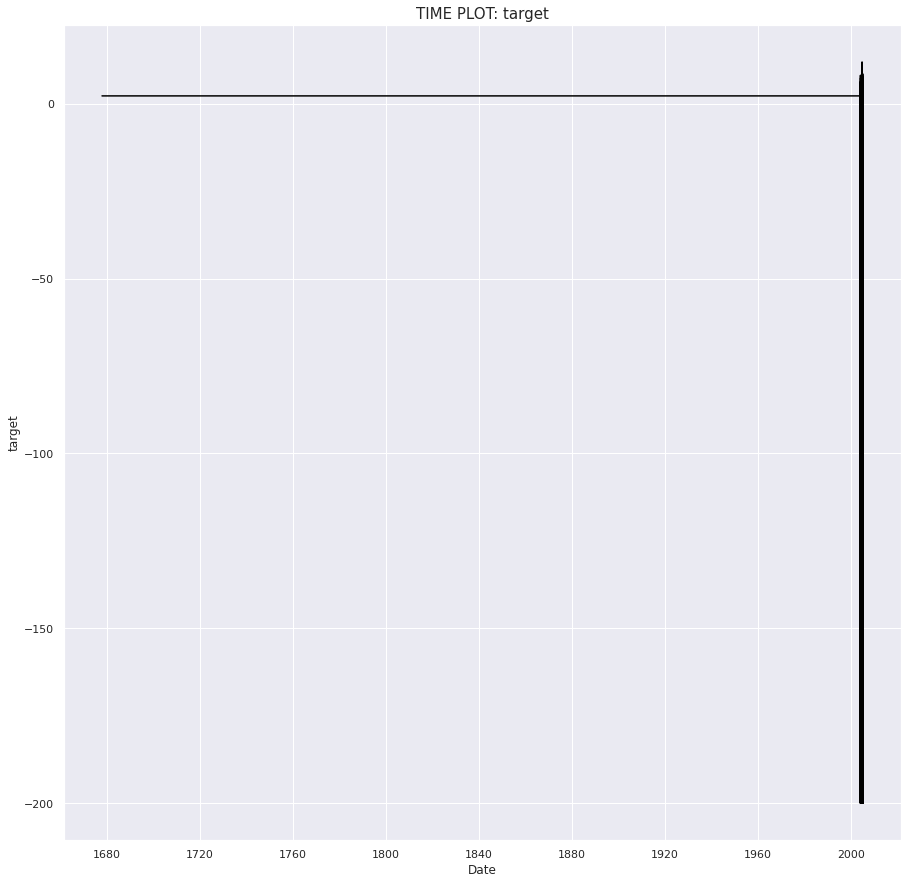

In [31]:
# Time plot: Original 
plt.title('TIME PLOT: '+forecast_column, size=15)
plt.ylabel(forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column], color='black')
plt.plot(main_df[date_column], main_df[forecast_column], color='black')
plt.show()

In [ ]:
# Time plot: log transformation
plt.title('TIME PLOT: '+'log('+forecast_column+')', size=15)
plt.ylabel(forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column], color='black')
plt.plot(main_df[date_column], main_df['log('+forecast_column+')'], color='black')
plt.show()

In [ ]:
# Mean evolution: original
plt.title('ROLLING MEAN EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Mean '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df[forecast_column].rolling(365*24).mean(), color='black')
plt.show()

In [ ]:
# Mean evolution: log transformation
plt.title('ROLLING MEAN EVOLUTION: '+'log('+forecast_column+')', size=15)
plt.ylabel('Mean '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df['log('+forecast_column+')'].rolling(365*24).mean(), color='black')
plt.show()

In [ ]:
# Deviation evolution: original
plt.title('VARIANCE EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Variance '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df[forecast_column].rolling(365*24).var(), color='black')
plt.show()

In [ ]:
# Deviation evolution: log transformation
plt.title('VARIANCE EVOLUTION: '+'log('+forecast_column+')', size=15)
plt.ylabel('Variance '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df['log('+forecast_column+')'].rolling(365*24).var(), color='black')
plt.show()

### 2.2 Check seasonal plot

In [ ]:
plt.title('SEASONAL PLOT: '+forecast_column, size=15)

years_list = main_df.index.year.unique()
for i, year in enumerate(years_list):
    df_i = main_df.loc[main_df.index.year==year]
    plt.plot(df_i.index.dayofyear, df_i[forecast_column], color='black', alpha=(1-i/len(years_list)), label=str(year))
plt.legend(loc="lower left", ncol=3)
plt.ylabel(forecast_column)
plt.xlabel('MONTH')
plt.show()

### 2.4 Autocorrelation

In [ ]:
# Autocorrelation and partial autocorrelation
plot_AC_and_PAC(main_df[forecast_column], lags=24*7) # Original
plot_AC_and_PAC(main_df['log('+forecast_column+')'], lags=24*7) # Log transformation

### 2.5 STL Decomposition

In [ ]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html
plt.rcParams['figure.figsize'] = 20,20
res = STL(main_df[forecast_column], period=12).fit()
fig = res.plot()
plt.show()
plt.rcParams['figure.figsize'] = (20, 5)

In [ ]:
# Strenth of components
# Reference: https://otexts.com/fpp2/seasonal-strength.html
Tt = getattr(res, 'trend') # smoothed trend component
St = getattr(res, 'seasonal') # seasonal component
Rt = getattr(res, 'resid') # remainder component

# Strenth of trend (0 - 1 | small - big trend)
Ft = max(0, 1-(np.var(Rt)/np.var(Tt+Rt)))
print("Strenth of trend: " +str(round(Ft,2)))

# Strenth of seasonality (0 - 1 | small - big seasonality)
Fs = max(0, 1-(np.var(Rt)/np.var(St+Rt)))
print("Strenth of seasonality: " +str(round(Fs,2)))

# Data Transformations

## kpss test
Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html

In [ ]:
kpss(main_df[forecast_column], 
     regression = 'c',    # stationary around a constant ‘c’ or a trend ‘ct’
     nlags = 'auto')

## .1 Differenciation

In [ ]:
lags = 12

In [ ]:
# https://otexts.com/fpp2/stationarity.html

# First order differencing
main_df['diff('+forecast_column+')'] = main_df[forecast_column] - main_df[forecast_column].shift(1)

# Second order differencing
main_df['diff(diff('+forecast_column+'))'] = main_df['diff('+forecast_column+')'] - (main_df[forecast_column].shift(1) - main_df[forecast_column].shift(2))


# Plotting
plot_AC_and_PAC(main_df[forecast_column], lags) # Original
plot_AC_and_PAC(main_df['diff('+forecast_column+')'].dropna(), lags) # First differencing
plot_AC_and_PAC(main_df['diff(diff('+forecast_column+'))'].dropna(), lags) # Second order differencing

In [ ]:
# https://otexts.com/fpp2/stationarity.html

# Seasonal differencing
main_df['lag-12 diff('+forecast_column+')'] = main_df[forecast_column] - main_df[forecast_column].shift(12)

# Second order differencing
main_df['diff(lag-12 diff('+forecast_column+'))'] = main_df['lag-12 diff('+forecast_column+')'] - (main_df[forecast_column].shift(1)-main_df[forecast_column].shift(13))

# Plotting
plot_AC_and_PAC(main_df[forecast_column], lags) # Original
plot_AC_and_PAC(main_df['lag-12 diff('+forecast_column+')'].dropna(), lags) # Seasonal differencing
plot_AC_and_PAC(main_df['diff(lag-12 diff('+forecast_column+'))'].dropna(), lags) # Seasonal differencing with further differencing

# 3 Model Fit

## 3.1 Train-test split

In [ ]:
separating_date = pd.to_datetime('19900101', format='%Y%m%d')
train_df = main_df.loc[main_df.index < separating_date]
test_df = main_df.loc[main_df.index >= separating_date]

# final_forecasting_date = pd.to_datetime('20200101', format='%Y%m%d')
# forecast_df = pd.DataFrame(
#     index = pd.date_range(start = main_df.index.max(), 
#                           end = final_forecasting_date, 
#                           freq='MS', closed='right') # frecuencies available https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
# )


# Visualise train test split
plt.title('Train - Test split')
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()

## 3.2 Exponential Smoothing

In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
ES = ExponentialSmoothing(train_df[forecast_column], 
                          trend = 'multiplicative',  #  {“additive”, “multiplicative”, None}
                          seasonal = 'multiplicative', #{“additive”, “multiplicative”, None}
                          seasonal_periods = 12,
                          damped = True).fit()

y_test_pred = ES.predict(start=test_df.index[0], end=test_df.index[-1])
y_train_pred = ES.predict(start=train_df.index[0], end=train_df.index[-1])
y_all_pred = ES.predict(start=train_df.index[0], end=test_df.index[-1])

In [ ]:
# PLOT

# Visualise forecast
plt.title('EXPONENTIAL SMOOTHING forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(train_df.index, y_train_pred, color='blue', label='model train')
plt.plot(test_df.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [ ]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column] - y_train_pred) / train_df[forecast_column]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column] - y_test_pred) / test_df[forecast_column]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

## 3.3 ARIMA

In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html
ARIMA_model = ARIMA(train_df[forecast_column], 
                    order=(13,1,0)).fit()
y_test_pred = ARIMA_model.predict(start=test_df.index[0], end=test_df.index[-1], typ='levels')
y_train_pred = ARIMA_model.predict(start=train_df.index[15], end=train_df.index[-1], typ='levels')
y_all_pred = ARIMA_model.predict(start=train_df.index[15], end=test_df.index[-1], typ='levels')

In [ ]:
# PLOT

# Visualise forecast
plt.title('EXPONENTIAL SMOOTHING forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [ ]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column][-len(y_train_pred):] - y_train_pred) / train_df[forecast_column][-len(y_train_pred):]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column][-len(y_train_pred):]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column][-len(y_train_pred):], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column][-len(y_test_pred):] - y_test_pred) / test_df[forecast_column][-len(y_test_pred):]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column][-len(y_test_pred):]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column][-len(y_test_pred):],y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

## 3.5 Prophet

In [ ]:
train_prophet = train_df[forecast_column].reset_index()
train_prophet.columns = ['ds','y']
test_prophet = test_df[forecast_column].reset_index()
test_prophet.columns = ['ds','y']

# Prophet https://facebook.github.io/prophet/docs/
m = Prophet(seasonality_mode='multiplicative', #seasonality_mode='multiplicative' or 'additive'
            interval_width=0.95,
            yearly_seasonality = True,
            #growth='logistic')
           )

# https://stackoverflow.com/questions/47534553/how-to-extract-seasonal-trends-from-prophet
#m.add_seasonality(name='weekly', period=7, fourier_order=3)

m.fit(train_prophet)

forecast_train = m.predict(train_prophet)
forecast_test = m.predict(test_prophet)

In [ ]:
y_train_pred = forecast_train[['ds','yhat']].set_index('ds',drop=True)
y_train_pred.index.name = None
y_train_pred = y_train_pred['yhat']

y_test_pred = forecast_test[['ds','yhat']].set_index('ds',drop=True)
y_test_pred.index.name = None
y_test_pred = y_test_pred['yhat']

y_all_pred = y_train_pred.append(y_test_pred)

In [ ]:
# PLOT

# Visualise forecast
plt.title('PROPHET forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [ ]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column] - y_train_pred) / train_df[forecast_column]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column] - y_test_pred) / test_df[forecast_column]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation